# **🫁 Lung Tumor Detection & Segmentation**



### ✅ Problem Definition & Dataset:

<details>
<summary><b><code>Dataset:<b></code></summary>

├── train\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── detections\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── images\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── masks\
└── val\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── detections\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── images\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── masks
- (detections, images, masks) in both trian & val should have subfolders one for each patient (subject).
- Images and masks should be corresponding to each other and named the same.
- Detections of each patient should include text files named with the scan number
- and each scan file includes a line or more of 4 numbers each (xMin, yMin, xMax, yMax)
</details>

\
**`Problem:`**
Building **Recognition & Detection models** for lung-cancer tumors

<details>
<summary><b><code>Solution:<b></code></summary>

1- Yolo Object Detection Model.  
2- UNet Segmentation Model for full images.  
3- Segmentation Model for cropped detection image.  
4- Compare Techniques 2 and 3
</details>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import random
import shutil
import yaml
from zipfile import ZipFile
from seaborn import color_palette
from sklearn.metrics import accuracy_score
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from data_wizard import DataWizard


c:\miniconda\envs\CV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global settings for plot styling
sns.set_style('darkgrid')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.major.bottom'] = False
plt.rcParams['ytick.major.left'] = False
plt.rcParams['axes.grid'] = False

data_loader = DataWizard()
data_loader.generate_dataset_files()

The dataset consists of 256 x 256 grayscale images

[Ordering Training Data  ]  Loaded [1832] Scans (1547 Cancer + 285 Healthy)
[Ordering Validation Data]  Loaded [98] Scans (78 Cancer + 20 Healthy)
#Source Paths =  3
#Source Paths =  3
#Source Paths =  3
#Source Paths =  3

[INFO]
Reorganized File Structure to:
-images/
-masks/
-detections/
-images_and_detections/
-cropped_images/
-cropped_masks/


### ✅ `Sample Scans`

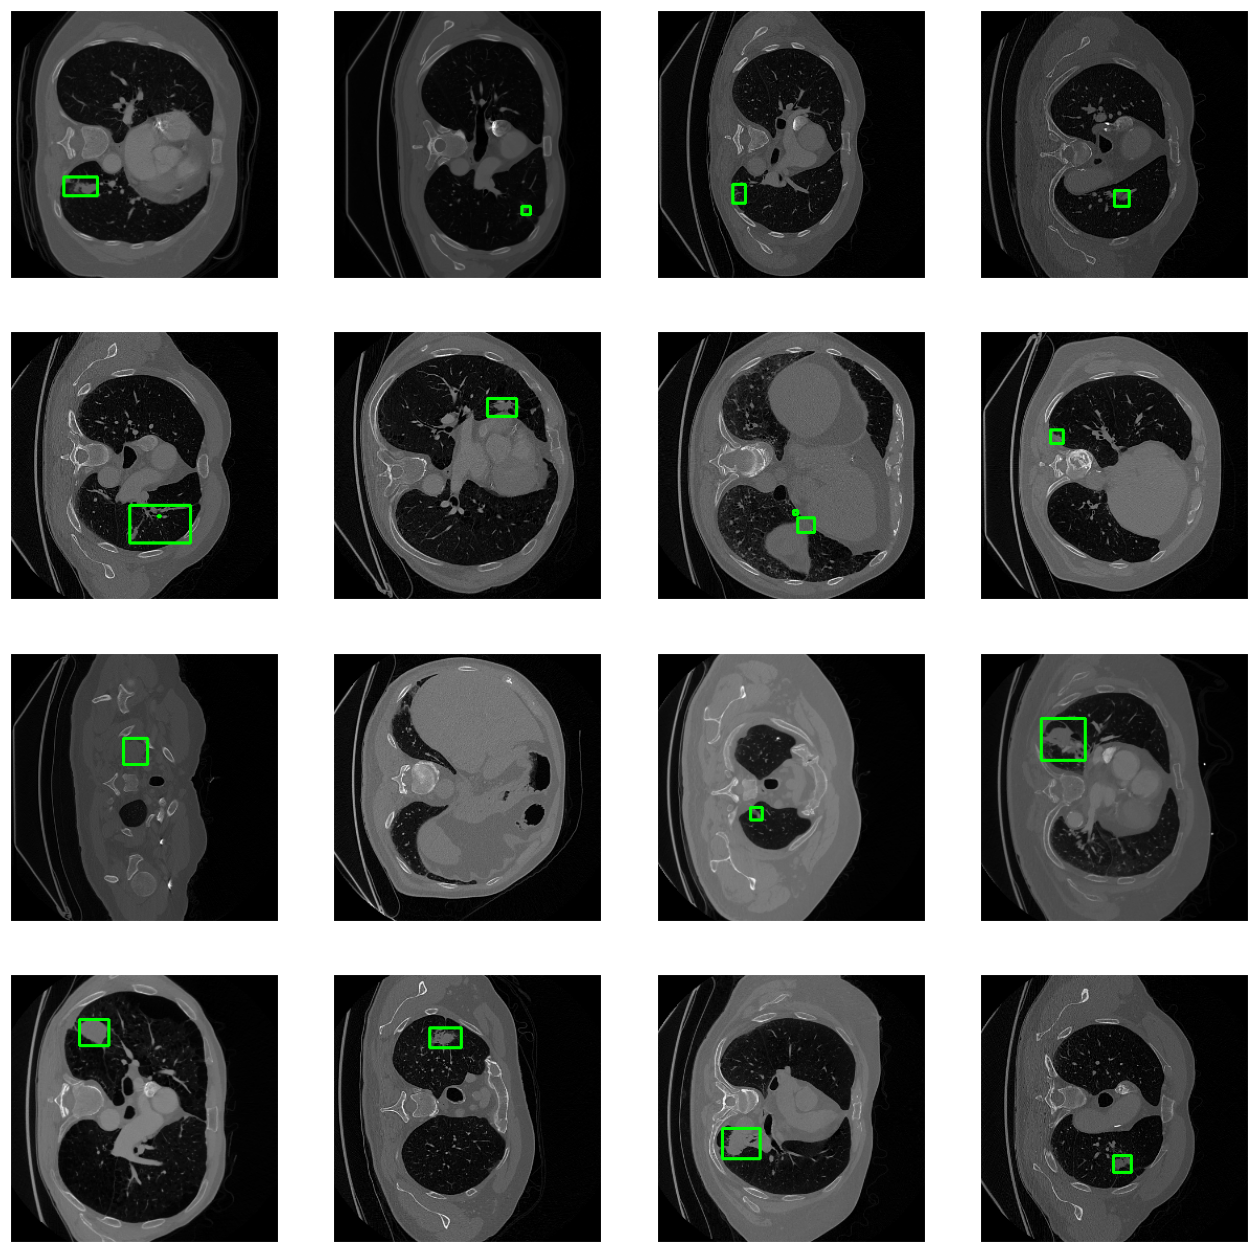

In [10]:
random_scans = data_loader.random_scans(16)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, scan in enumerate(random_scans):
    row = i // 4
    col = i % 4
    image, detections = scan
    if len(detections) <= 0:
        axes[row, col].imshow(image)
        continue
    for xmin, ymin, xmax, ymax in detections:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    axes[row, col].imshow(image)
plt.show()

# ⚡ **`Task1- Object Detection`** [YOLO]

### ✅ Training:

<details>
    <summary><b><code>Metrics Explanation:</code></b></summary>

- `Train Box Loss:`\
Measures the difference between the predicted bounding boxes and the actual bounding boxes of the objects in the training data.\
A lower box loss means that the model's predicted bounding boxes more closely align with the actual bounding boxes.

- `Train Class Loss:`\
Measures the difference between the predicted class probabilities and the actual class labels of the objects in the training data.\
lower class loss means that the model's predicted class probabilities more closely align with the actual class labels.

- `Train DFL Loss:`\
DFL (Dynamic Feature Learning) loss metric measures the difference between the predicted feature map\
and the actual feature maps of the objects in the training data.\
A lower DFL loss means that the model's predicted feature maps more closely align with the actual feature maps.

- `Precision:`\
Measures the proportion of true positive detections among all the predicted bounding boxes.\
A higher precision means that the model is better at correctly identifying true positive detections and minimizing false positives.

- `Recall:`\
Measures the proportion of true positive detections among all the actual bounding boxes.\
A higher recall means that the model is better at correctly identifying all true positive detections and minimizing false negatives.

- `mAP50:`\
Mean Average Precision of the model across different object categories,\
with a 50% intersection-over-union (IoU) threshold.\
A higher mAP50 means that the model is better at accurately detecting and localizing objects across different categories.

- `mAP50-95:`\
Mean average precision of the model across different object categories, with IoU thresholds ranging from 50% to 95%.\
A higher mAP50-95 means that the model is better at accurately detecting and localizing objects\
across different categories with a wider range of IoU thresholds.
</details>

In [ ]:
yolo_config = '''
train: train/images_and_detections
val: val/images_and_detections
nc: 1
names: ['tumor']
'''
with open('yolov8_config.yaml', "w") as file:
    file.write(yolo_config)

from ultralytics import YOLO
YOLO_model = YOLO('models/yolov8x.pt')
YOLO_model.train(task='detect',
            data='yolov8_config.yaml',
            optimizer='AdamW',
            device='cuda',
            imgsz=256,
            lr0=0.0001,
            batch=16,
            epochs=40,
            weight_decay=0.05,
            patience=30,
            workers=0)

### **✅ Evaluation:**

`Predict & Evaluate the model (for train / validation)`

In [ ]:
train_detection_results = YOLO_model.predict(source='datasets/train/images/',
                                        save_txt=True,
                                        project='datasets/train/predicted_detections'
                                        name='output')
val_detection_results = YOLO_model.predict(source='datasets/val/images/',
                                      save_txt=True,
                                      project='datasets/val/predicted_detections'
                                      name='output')
detection_metrics = YOLO_model.val(conf=0.1, split='train')
detection_metrics = YOLO_model.val(conf=0.1, split='val')

`Confusion Mattrix`

In [ ]:
confusion_matrix_img = mpimg.imread('/content/runs/detect/train/confusion_matrix.png')
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(confusion_matrix_img)
ax.axis('off');

In [ ]:
metrics = YOLO_model.val()
print(metrics)

# ⚡ **`Task2: Semantic Segmentation On Full Image`** [UNet]

<details>
<summary><code>UNet Model</code></summary>

is designed for image segmentation, utilizing an encoder-decoder structure\
with skip connections to preserve spatial information.\
It is particularly effective for tasks requiring pixel-wise predictions.

<img title="UNet Architecture" alt="UNet Architecture Diagram" src="resources/UNet_archi.jpg">
</details>

### **✅ Training:**

In [ ]:
train_images, train_masks = data_wizard.load_dataset(data_wizard.train_path)
val_images, val_masks = data_wizard.load_dataset(data_wizard.val_path)

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    
    # Concatenate with c3, ensure same size by cropping if necessary
    merge1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    
    # Concatenate with c2, ensure same size by cropping if necessary
    merge2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    
    # Concatenate with c1, ensure same size by cropping if necessary
    merge3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge3)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c6)
    model = Model(inputs, outputs)
    return model

target_size=(256,256)
model = build_unet(input_shape=(target_size[0], target_size[1], 3))
model.compile(optimizer='adamW', loss='binary_crossentropy', metrics=['accuracy'])

print('[Training Full Image UNet]')
model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10, batch_size=8)
print(' Done')
model.save_weights("/content/UNet.weights.h5")

Training the model...
Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 91s 260ms/step - accuracy: 0.9696 - loss: 0.0891 - val_accuracy: 0.9984 - val_loss: 0.0091
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 94s 164ms/step - accuracy: 0.9955 - loss: 0.0193 - val_accuracy: 0.9984 - val_loss: 0.0101
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9958 - loss: 0.0140 - val_accuracy: 0.9985 - val_loss: 0.0056
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 0.9988 - val_loss: 0.0033
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - accuracy: 0.9977 - loss: 0.0069 - val_accuracy: 0.9989 - val_loss: 0.0033
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.9984 - loss: 0.0043 - val_accuracy: 0.9990 - val_loss: 0.0045
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.9986 - loss: 0.0039 - val_accuracy: 0.9990 - val_loss: 0.0032
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accu

### **✅ Evaluation:**

**`Save the predicted masks`**

In [ ]:
def save_predicted_masks(predictions, image_names, save_dir, threshold=0.5, debug=False):
    os.makedirs(save_dir, exist_ok=True)
    for i, (pred, name) in enumerate(zip(predictions, image_names)):
        pred_binary = (pred > threshold).astype(np.uint8) * 255

        pred_binary = np.squeeze(pred_binary, axis=-1)

        pred_binary_3d = np.expand_dims(pred_binary, axis=-1)

        save_path = os.path.join(save_dir, name)
        save_img(save_path, pred_binary_3d)

print("Predicting masks for training images...")
train_preds = model.predict(train_images)

train_save_dir = '/content/LungTumorDetectionAndSegmentation/train/predicted_full_images_masks'
print("Saving predicted masks for training data...")
save_predicted_masks(train_preds, train_names, train_save_dir)

print("Predicting masks for validation images...")
val_preds = model.predict(val_images)

val_save_dir = '/content/LungTumorDetectionAndSegmentation/val/predicted_full_images_masks'
print("Saving predicted masks for validation data...")
save_predicted_masks(val_preds, val_names, val_save_dir)

print("All predicted masks saved successfully!")

Predicting masks for training images...
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step
Saving predicted masks for training data...
Predicting masks for validation images...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
Saving predicted masks for validation data...
All predicted masks saved successfully!


**`Calculate the accuracy for train and validation dataset`**

In [ ]:
def load_and_preprocess_mask(mask_path, target_size=(256, 256)):
    mask = load_img(mask_path, target_size=target_size)
    mask_array = img_to_array(mask) / 255.0
    mask_array = np.round(mask_array)
    return mask_array

def white_pixel_accuracy(pred_mask, true_mask):
    white_pixel_indices = true_mask > 0.5
    if np.sum(white_pixel_indices) == 0:
        return 1.0

    true_white = true_mask[white_pixel_indices]
    pred_white = pred_mask[white_pixel_indices]

    accuracy_metric = tf.keras.metrics.BinaryAccuracy()
    accuracy_metric.update_state(true_white, pred_white)
    return accuracy_metric.result().numpy()

def calculate_average_white_pixel_accuracy(predicted_masks_dir, actual_masks_dir, target_size=(256, 256)):
    predicted_masks = sorted(os.listdir(predicted_masks_dir))
    actual_masks = sorted(os.listdir(actual_masks_dir))

    num_images = len(actual_masks)
    total_accuracy = 0

    for pred_mask_file, true_mask_file in zip(predicted_masks, actual_masks):
        pred_mask_path = os.path.join(predicted_masks_dir, pred_mask_file)
        true_mask_path = os.path.join(actual_masks_dir, true_mask_file)

        predicted_mask = load_and_preprocess_mask(pred_mask_path, target_size)
        actual_mask = load_and_preprocess_mask(true_mask_path, target_size)

        accuracy = white_pixel_accuracy(predicted_mask, actual_mask)
        total_accuracy += accuracy

    return total_accuracy / num_images

dataset_paths = {
    "training": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/train/predicted_full_images_masks",
        "actual": "/content/LungTumorDetectionAndSegmentation/train/masks"
    },
    "validation": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/val/predicted_full_images_masks",
        "actual": "/content/LungTumorDetectionAndSegmentation/val/masks"
    }
}

for dataset_type, paths in dataset_paths.items():
    avg_accuracy = calculate_average_white_pixel_accuracy(paths["predicted"], paths["actual"])
    print(f"Average White Pixel Accuracy for {dataset_type.capitalize()} Dataset: {avg_accuracy}")


Average Pixel Accuracy for Training Dataset: 0.9987480463419419
Average Pixel Accuracy for Validation Dataset: 0.9989516589106345


# **⚡Task4: Evaluating UNet Model Trained on Full Images Using Cropped Detections By Yolo**




## **✅Cropped Tumor Detection:**

In [ ]:
def load_yolo_detections_predictions(annotations_path):
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()
    bboxes = []
    for annotation in annotations:
        parts = annotation.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        bboxes.append((class_id, x_center, y_center, width, height))
    return bboxes

def crop_and_save_image(image, annotations, image_name, save_dir, image_width, image_height):
    for i, (class_id, x_center, y_center, width, height) in enumerate(annotations):
        x1 = int((x_center - width / 2) * image_width)
        y1 = int((y_center - height / 2) * image_height)
        x2 = int((x_center + width / 2) * image_width)
        y2 = int((y_center + height / 2) * image_height)

        cropped_image = image[y1:y2, x1:x2]
        cropped_filename = f"{os.path.splitext(image_name)[0]}_tumor{i+1}.png"

        save_path = os.path.join(save_dir, cropped_filename)
        cv2.imwrite(save_path, cropped_image)

def process_images(image_folder, annotations_folder, save_dir, target_size=(256, 256)):
    os.makedirs(save_dir, exist_ok=True)
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for image_name in tqdm(image_files):
        image_path = os.path.join(image_folder, image_name)
        annotations_path = os.path.join(annotations_folder, f"{os.path.splitext(image_name)[0]}.txt")

        if not os.path.exists(annotations_path):
            continue

        image = cv2.imread(image_path)
        image_height, image_width = image.shape[:2]

        annotations = load_yolo_detections_predictions(annotations_path)
        crop_and_save_image(image, annotations, image_name, save_dir, image_width, image_height)


train_image_folder = '/content/LungTumorDetectionAndSegmentation/train/images'
train_mask_folder = '/content/LungTumorDetectionAndSegmentation/train/masks'
train_annotations_folder = '/content/LungTumorDetectionAndSegmentation/train/predicted_images_and_detections/output/labels'
train_images_save_dir = '/content/LungTumorDetectionAndSegmentation/train/cropped_images_with_pred_detections'
train_masks_save_dir = '/content/LungTumorDetectionAndSegmentation/train/cropped_masks_with_pred_detections'

print("Processing training images...")
process_images(train_image_folder, train_annotations_folder, train_images_save_dir)
process_images(train_mask_folder, train_annotations_folder, train_masks_save_dir)

val_image_folder = '/content/LungTumorDetectionAndSegmentation/val/images'
val_mask_folder = '/content/LungTumorDetectionAndSegmentation/val/masks'
val_annotations_folder = '/content/LungTumorDetectionAndSegmentation/val/predicted_images_and_detections/output/labels'
val_images_save_dir = '/content/LungTumorDetectionAndSegmentation/val/cropped_images_with_pred_detections'
val_masks_save_dir = '/content/LungTumorDetectionAndSegmentation/val/cropped_masks_with_pred_detections'

print("Processing validation images...")
process_images(val_image_folder, val_annotations_folder, val_images_save_dir)
process_images(val_mask_folder, val_annotations_folder, val_masks_save_dir)

Processing training images...


100%|██████████| 1832/1832 [00:00<00:00, 2385.76it/s]


Processing validation images...


100%|██████████| 98/98 [00:00<00:00, 2826.93it/s]


## **✅Apply Segmentation:**

In [ ]:
model = build_unet(input_shape=(256, 256, 3))
model_path = '/content/UNet.weights.h5'
model.load_weights(model_path)

cropped_train_images_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_images_with_pred_detections'
cropped_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_masks_with_pred_detections'
predicted_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/predicted_masks_pred_detections'

print("Loading and predicting masks for training cropped images...")
cropped_train_images,cropped_train_masks, train_image_names = load_dataset(cropped_train_images_folder,cropped_train_masks_folder, target_size=(256, 256))
train_masks_predictions = model.predict(cropped_train_images)
save_predicted_masks(train_masks_predictions, train_image_names, predicted_train_masks_folder)

cropped_val_images_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_images_with_pred_detections'
cropped_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_masks_with_pred_detections'
predicted_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/predicted_masks_pred_detections'

print("Loading and predicting masks for validation cropped images...")
cropped_val_images,cropped_val_masks, val_image_names = load_dataset(cropped_val_images_folder,cropped_val_masks_folder, target_size=(256, 256))
val_masks_predictions = model.predict(cropped_val_images)
save_predicted_masks(val_masks_predictions, val_image_names, predicted_val_masks_folder)

print("Prediction and saving of masks completed.")


Loading and predicting masks for training cropped images...
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step
Loading and predicting masks for validation cropped images...
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Prediction and saving of masks completed.


## **✅Evaluation:**

In [ ]:
dataset_paths = {
    "training": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/train/predicted_masks_pred_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/train/masks"
    },
    "validation": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/val/predicted_masks_pred_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/val/masks"
    }
}

for dataset_type, paths in dataset_paths.items():
    avg_accuracy = calculate_average_pixel_accuracy(paths["predicted"], paths["actual"])
    print(f"Average Pixel Accuracy for {dataset_type.capitalize()} Dataset: {avg_accuracy}")

Average Pixel Accuracy for Training Dataset: 0.7437627117706699
Average Pixel Accuracy for Validation Dataset: 0.6281873741928412


# **⚡Task5: UNet Segmentation Model Trained on Cropped Masks**

## **✅Training:**

In [ ]:
cropped_train_images_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_images'
cropped_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_masks'

print("Loading and predicting masks for training cropped images...")
cropped_train_images,cropped_train_masks, train_image_names = load_dataset(cropped_train_images_folder,cropped_train_masks_folder, target_size=(256, 256))

cropped_val_images_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_images'
cropped_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_masks'

print("Loading and predicting masks for validation cropped images...")
cropped_val_images, cropped_val_masks, val_image_names = load_dataset(cropped_val_images_folder,cropped_val_masks_folder, target_size=(256, 256))

model = build_unet(input_shape=(target_size[0], target_size[1], 3))
model.compile(optimizer='adamW', loss='binary_crossentropy', metrics=['accuracy'])

print("Training the model...")
model.fit(cropped_train_images, cropped_train_masks, validation_data=(cropped_val_images, cropped_val_masks), epochs=10, batch_size=8)
model.save_weights("/content/UNet_cropped_images.weights.h5")

Loading and predicting masks for training cropped images...
Loading and predicting masks for validation cropped images...
Training the model...
Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 77s 319ms/step - accuracy: 0.5971 - loss: 0.5837 - val_accuracy: 0.5861 - val_loss: 0.5159
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 45s 164ms/step - accuracy: 0.6436 - loss: 0.4893 - val_accuracy: 0.6712 - val_loss: 0.4528
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.6586 - loss: 0.4661 - val_accuracy: 0.6486 - val_loss: 0.4521
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.6637 - loss: 0.4638 - val_accuracy: 0.6805 - val_loss: 0.4228
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.6760 - loss: 0.4577 - val_accuracy: 0.6703 - val_loss: 0.4382
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 35s 167ms/step - accuracy: 0.6856 - loss: 0.4378 - val_accuracy: 0.6751 - val_loss: 0.4336
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - accuracy: 0.6

In [ ]:
predicted_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/predicted_masks_actual_detections'
train_masks_predictions = model.predict(cropped_train_images)
save_predicted_masks(train_masks_predictions, train_image_names, predicted_train_masks_folder)

predicted_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/predicted_masks_actual_detections'
val_masks_predictions = model.predict(cropped_val_images)
save_predicted_masks(val_masks_predictions, val_image_names, predicted_val_masks_folder)

print("Prediction and saving of masks completed.")

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step
Prediction and saving of masks completed.


## **✅Evaluation:**

In [ ]:
dataset_paths = {
    "training": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/train/predicted_masks_actual_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/train/masks"
    },
    "validation": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/val/predicted_masks_actual_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/val/masks"
    }
}

for dataset_type, paths in dataset_paths.items():
    avg_accuracy = calculate_average_pixel_accuracy(paths["predicted"], paths["actual"])
    print(f"Average Pixel Accuracy for {dataset_type.capitalize()} Dataset: {avg_accuracy}")

Average Pixel Accuracy for Training Dataset: 0.15636942167990073
Average Pixel Accuracy for Validation Dataset: 0.15222105687978316
